# base model

In [10]:
import os
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from datasets import load_dataset

# Load dataset
dataset_dict = load_dataset("deepcopy/MathWriting-human")

# Set this config for percentage of the data
USE_PERCENTAGE = 0.05
train_samples = int(USE_PERCENTAGE * len(dataset_dict["train"]))
val_samples = int(USE_PERCENTAGE * len(dataset_dict["val"]))

train_small = dataset_dict["train"].select(range(train_samples))
val_small = dataset_dict["val"].select(range(val_samples))

# Add binary_label
latex_pool = train_small["latex"]

def add_binary_label(example):
    if random.random() > 0.5:
        example["binary_label"] = 1
        example["latex_used"] = example["latex"]
    else:
        wrong_latex = random.choice(latex_pool)
        while wrong_latex == example["latex"]:
            wrong_latex = random.choice(latex_pool)
        example["binary_label"] = 0
        example["latex_used"] = wrong_latex
    return example

train_small = train_small.map(add_binary_label)
val_small = val_small.map(add_binary_label)

def hf_to_tf_dataset(hf_dataset, batch_size=16):
    def gen():
        for ex in hf_dataset:
            img_array = ex["image"]["array"] if isinstance(ex["image"], dict) and "array" in ex["image"] else ex["image"]
            img = tf.image.resize(tf.image.convert_image_dtype(img_array, tf.float32), (224, 224))
            label = ex["binary_label"]
            yield img, label

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    tf_dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    tf_dataset = tf_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tf_dataset

tf_train = hf_to_tf_dataset(train_small)
tf_val = hf_to_tf_dataset(val_small)

vision_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vision_base.trainable = False

vision_head = models.Sequential([
    vision_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu')
])

vision_input = layers.Input(shape=(224, 224, 3), name="vision_input")
vision_features = vision_head(vision_input)
x = layers.Dense(64, activation='relu')(vision_features)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=vision_input, outputs=output, name="base_model")

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=3,
    verbose=1
)

Epoch 1/3
    719/Unknown 104s 105ms/step - accuracy: 0.5141 - loss: 0.6951

2025-07-18 01:28:17.521594: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


719/719 ━━━━━━━━━━━━━━━━━━━━ 123s 132ms/step - accuracy: 0.5141 - loss: 0.6951 - val_accuracy: 0.4840 - val_loss: 0.6942
Epoch 2/3


2025-07-18 01:28:36.793924: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5896140352272772973


719/719 ━━━━━━━━━━━━━━━━━━━━ 66s 91ms/step - accuracy: 0.5079 - loss: 0.6934 - val_accuracy: 0.4840 - val_loss: 0.6938
Epoch 3/3


2025-07-18 01:29:42.694076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5896140352272772973


719/719 ━━━━━━━━━━━━━━━━━━━━ 66s 91ms/step - accuracy: 0.5096 - loss: 0.6935 - val_accuracy: 0.4840 - val_loss: 0.6936


2025-07-18 01:30:48.887851: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5896140352272772973
2025-07-18 01:30:48.887926: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 17709485556187959722


In [11]:
# Model summary
model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vision_input (InputLayer)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128)            │     4,213,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,566,440 (17.42 MB)

 Trainable params: 172,289 (673.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 344,580 (1.31 MB)

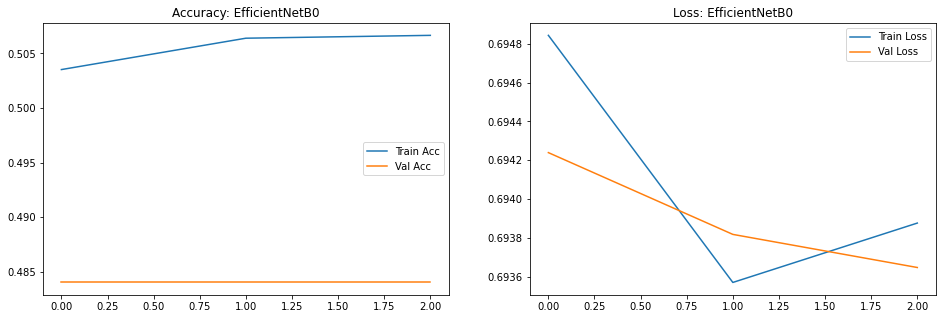

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy: EfficientNetB0')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss: EfficientNetB0')

plt.show()

In [13]:
model.save("models/basemodel.h5")
model.save("models/basemodel.keras")

For a basic base model the model looks like it is making some form of inference. Further research and work is needed.

In [ ]:
# end of model1 base model build and test runs